# GRADED CHALLENGE 2

## I. Introduction

Nama: Nurrahmawati

Batch: FTDS-002

Dataset: Census adult income

Object: Adult Income Bracket Prediction

Data extraction from Bigquery using Google Cloud Platform (Bigquery-public-data table census_adult_income based on dataset in ml_datasets ) 
```txt
SELECT age,
      workclass,
      education,
      education_num,
      marital_status,
      occupation,
      relationship,
      race,
      sex,
      capital_gain,
      capital_loss,
      hours_per_week,
      native_country,
      income_bracket
FROM `bigquery-public-data.ml_datasets.census_adult_income` 
WHERE workclass NOT LIKE '%?%' AND
      hours_per_week < 100
LIMIT 3996
```

## II. Import Libraries

In [1]:
# Define Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# For Classifier Problems
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

from feature_engine.outliers import Winsorizer

# Evaluate Regression Models
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

# Error and Display settings
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings('ignore')

## III. Data Loading

In [2]:
# Load Census Adult Income Dataset
data = pd.read_csv('h8dsft_P1G2_Nurrahmawati.csv')
data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K
1,37,Private,12th,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,?,<=50K
2,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,>50K
3,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
4,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States,<=50K


In [3]:
data.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
3991,67,Private,HS-grad,9,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,20,United-States,<=50K
3992,18,Private,10th,6,Never-married,Priv-house-serv,Own-child,Black,Female,0,0,20,United-States,<=50K
3993,17,Private,11th,7,Never-married,Priv-house-serv,Own-child,White,Female,0,0,20,United-States,<=50K
3994,20,Private,Some-college,10,Never-married,Priv-house-serv,Own-child,White,Female,0,0,20,United-States,<=50K
3995,53,Private,HS-grad,9,Divorced,Priv-house-serv,Not-in-family,White,Female,0,0,20,United-States,<=50K


In [4]:
# Checking Basic Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3996 entries, 0 to 3995
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             3996 non-null   int64 
 1   workclass       3996 non-null   object
 2   education       3996 non-null   object
 3   education_num   3996 non-null   int64 
 4   marital_status  3996 non-null   object
 5   occupation      3996 non-null   object
 6   relationship    3996 non-null   object
 7   race            3996 non-null   object
 8   sex             3996 non-null   object
 9   capital_gain    3996 non-null   int64 
 10  capital_loss    3996 non-null   int64 
 11  hours_per_week  3996 non-null   int64 
 12  native_country  3996 non-null   object
 13  income_bracket  3996 non-null   object
dtypes: int64(5), object(9)
memory usage: 437.2+ KB


Based on this information data, it can be seen that there are two types of this data, there are int64 and object types. In addition, it can be seen that this data represents all of them with 3996 data entries which can be interpreted as no missing values

In [5]:
for i in data.select_dtypes(include=['object']).columns.tolist():
    print(i, '\n')
    print(data.select_dtypes(include=['object'])[i].value_counts())
    print('-'*30)

workclass 

 Private             2874
 Self-emp-not-inc     437
 Local-gov            254
 State-gov            229
 Self-emp-inc         125
 Federal-gov           71
 Without-pay            4
 Never-worked           2
Name: workclass, dtype: int64
------------------------------
education 

 Some-college    1118
 HS-grad         1078
 Bachelors        491
 11th             310
 Masters          167
 10th             162
 Assoc-voc        119
 Assoc-acdm       117
 12th              87
 7th-8th           86
 9th               69
 Prof-school       69
 Doctorate         48
 5th-6th           35
 1st-4th           33
 Preschool          7
Name: education, dtype: int64
------------------------------
marital_status 

 Never-married            1838
 Married-civ-spouse       1335
 Divorced                  441
 Widowed                   219
 Separated                 108
 Married-spouse-absent      52
 Married-AF-spouse           3
Name: marital_status, dtype: int64
-------------------------

There are unique values ​​`?` in occupation column with 2 entries and native_country column with 67 entries which we don't understand the meaning of the data, so in the next session we will replace it to NaN and then it will be handled by dropping the unique so that the data we want to enter into in the model can run well as we want

In [6]:
# Check Percentage Missing Values
data.isnull().mean()

age               0.0
workclass         0.0
education         0.0
education_num     0.0
marital_status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital_gain      0.0
capital_loss      0.0
hours_per_week    0.0
native_country    0.0
income_bracket    0.0
dtype: float64

In [7]:
# Checking data duplicated
data[data.duplicated()].shape

(259, 14)

There are 259 entries duplicated data and we will remove it later in cleaning section.

In [8]:
# Checking Basic Statistics 
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,3996.0,37.090841,17.148399,17.0,22.0,33.0,49.0,90.0
education_num,3996.0,9.715716,2.591555,1.0,9.0,10.0,11.0,16.0
capital_gain,3996.0,771.606106,6450.569689,0.0,0.0,0.0,0.0,99999.0
capital_loss,3996.0,75.508759,379.439805,0.0,0.0,0.0,0.0,4356.0
hours_per_week,3996.0,32.104855,24.008025,1.0,15.0,20.0,46.0,99.0


Based on an overview:
- There is high cardinality in columns, which we will be simplified into more general groups workclass and occupation
- There is a unique value `?` which will be replaced into a NaN value so we need to clean it
- The `income_bracket` data type is the `object` that we will target and we need to change the data type to `category`
- there are duplicate entries which we will clean up in the next section

## IV. DATA CLEANING

In [9]:
data_clean = data.copy()
data_clean.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K
1,37,Private,12th,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,?,<=50K
2,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,>50K
3,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
4,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States,<=50K


In [10]:
data_clean['occupation'].unique()

array([' ?', ' Sales', ' Adm-clerical', ' Armed-Forces', ' Craft-repair',
       ' Tech-support', ' Other-service', ' Prof-specialty',
       ' Exec-managerial', ' Farming-fishing', ' Priv-house-serv',
       ' Protective-serv', ' Transport-moving', ' Handlers-cleaners',
       ' Machine-op-inspct'], dtype=object)

In [11]:
data_clean['native_country'].unique()

array([' United-States', ' ?', ' Dominican-Republic', ' Canada', ' South',
       ' Cuba', ' Mexico', ' Vietnam', ' Philippines', ' India', ' Italy',
       ' Jamaica', ' El-Salvador', ' Trinadad&Tobago', ' Guatemala',
       ' England', ' Germany', ' Puerto-Rico', ' Peru', ' Yugoslavia',
       ' Poland', ' Iran', ' Taiwan', ' Hong', ' Japan', ' Thailand',
       ' Haiti', ' China', ' Ecuador', ' Columbia', ' Greece', ' France',
       ' Hungary', ' Laos', ' Outlying-US(Guam-USVI-etc)', ' Portugal',
       ' Nicaragua', ' Honduras', ' Scotland'], dtype=object)

In [12]:
# Replace '?' to NaN value
data_clean.replace(' ?', np.NaN, inplace=True)

In [13]:
# Recheck percentage missing values before remove
data_clean.iloc[:,[5,12]].isnull().mean()

occupation        0.000501
native_country    0.016767
dtype: float64

After converting unique `?` to `NaN`, the data becomes missing values ​​with a percentage of less than 0.1% which we will handle with the dropping method

In [14]:
# Remove missing values in price column
data_clean.dropna(inplace=True)

# Percentage missing values after remove
data_clean.iloc[:,[5,12]].isnull().mean()

occupation        0.0
native_country    0.0
dtype: float64

In [15]:
# shape of dataframe before remove duplicates
data_clean[data_clean.duplicated()].shape

(259, 14)

In [16]:
# Remove duplicated data
data_clean.drop_duplicates(inplace=True)

# shape of dataframe after remove duplicates
data_clean[data_clean.duplicated()].shape

(0, 14)

In [17]:
# Converting the type of `income bracket` column
data_clean['income_bracket']=data_clean['income_bracket'].astype('category')

In [18]:
num_col = data_clean.describe().columns.tolist()
cat_col = data_clean.select_dtypes(include=['object']).columns.tolist()

**Numeric overview**

In [19]:
# numeric overview
data_clean[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
age,3668.0,38.281897,17.030624,17.0,23.0,35.0,50.0,90.0
education_num,3668.0,9.773446,2.610771,1.0,9.0,10.0,11.0,16.0
capital_gain,3668.0,833.883043,6726.017835,0.0,0.0,0.0,0.0,99999.0
capital_loss,3668.0,80.697655,391.825351,0.0,0.0,0.0,0.0,4356.0
hours_per_week,3668.0,33.033806,24.421140,1.0,15.0,20.0,47.0,99.0


**Categorical overview**

In [20]:
for i in data_clean[cat_col].columns.tolist():
    print(f'num of unique label in {i}: ', len(data_clean[cat_col][i].unique()))

num of unique label in workclass:  7
num of unique label in education:  16
num of unique label in marital_status:  7
num of unique label in occupation:  14
num of unique label in relationship:  6
num of unique label in race:  5
num of unique label in sex:  2
num of unique label in native_country:  38


In [21]:
for i in data_clean[cat_col].columns.tolist():
    print(i, '\n')
    print(data_clean[cat_col][i].value_counts().head())
    print('-'*30)

workclass 

 Private             2579
 Self-emp-not-inc     430
 Local-gov            249
 State-gov            222
 Self-emp-inc         117
Name: workclass, dtype: int64
------------------------------
education 

 HS-grad         1034
 Some-college     983
 Bachelors        473
 11th             242
 Masters          162
Name: education, dtype: int64
------------------------------
marital_status 

 Never-married         1558
 Married-civ-spouse    1302
 Divorced               433
 Widowed                214
 Separated              106
Name: marital_status, dtype: int64
------------------------------
occupation 

 Other-service      683
 Sales              532
 Adm-clerical       522
 Prof-specialty     506
 Exec-managerial    307
Name: occupation, dtype: int64
------------------------------
relationship 

 Husband          1053
 Own-child         964
 Not-in-family     923
 Unmarried         382
 Wife              226
Name: relationship, dtype: int64
------------------------------
ra

The `workclass` and `occupation` columns will be simplified into more general groups.
with this handling process, we can minimize/change unique labels from 7 to 3 unique labels for work class column, and from 14 to 6 unique labels for work column

In [22]:
# Aggregating values 
data_clean.loc[ data_clean['workclass'] == ' Local-gov', 'workclass'] = ' Government'
data_clean.loc[ data_clean['workclass'] == ' Federal-gov', 'workclass'] = ' Government'
data_clean.loc[ data_clean['workclass'] == ' State-gov', 'workclass'] = ' Government'
data_clean.loc[ data_clean['workclass'] == ' Self-emp-inc', 'workclass'] = ' Self-emp'
data_clean.loc[ data_clean['workclass'] == ' Self-emp-not-inc', 'workclass'] = ' Self-emp'
data_clean.loc[ data_clean['workclass'] == ' Without-pay', 'workclass'] = ' Self-emp'

data_clean['workclass'].value_counts()

 Private       2579
 Self-emp       551
 Government     538
Name: workclass, dtype: int64

In [23]:
# Aggregating values 
data_clean.loc[ data_clean['occupation'] == ' Machine-op-inspct', 'occupation'] = ' Technical-serv'
data_clean.loc[ data_clean['occupation'] == ' Tech-support', 'occupation'] = ' Technical-serv'
data_clean.loc[ data_clean['occupation'] == ' Craft-repair', 'occupation'] = ' Technical-serv'
data_clean.loc[ data_clean['occupation'] == ' Handlers-cleaners', 'occupation'] = ' Home-serv'
data_clean.loc[ data_clean['occupation'] == ' Priv-house-serv', 'occupation'] = ' Home-serv'
data_clean.loc[ data_clean['occupation'] == ' Protective-serv', 'occupation'] = ' Home-serv'

In [24]:
retain_occupation = data_clean['occupation'].value_counts().head().index.tolist().copy()
retain_occupation

occu_manipulated = []

for i in data_clean['occupation']:
    if i in retain_occupation:
        occu_manipulated.append(i)
    else:
        occu_manipulated.append('Others')

data_clean['occupation'] = occu_manipulated.copy()
data_clean['occupation'].value_counts()

Others             914
 Other-service     683
 Sales             532
 Adm-clerical      522
 Technical-serv    511
 Prof-specialty    506
Name: occupation, dtype: int64

In [25]:
for i in data_clean[cat_col].columns.tolist():
    print(f'num of unique label in {i}: ', len(data_clean[cat_col][i].unique()))

num of unique label in workclass:  3
num of unique label in education:  16
num of unique label in marital_status:  7
num of unique label in occupation:  6
num of unique label in relationship:  6
num of unique label in race:  5
num of unique label in sex:  2
num of unique label in native_country:  38


In [26]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3668 entries, 2 to 3995
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             3668 non-null   int64   
 1   workclass       3668 non-null   object  
 2   education       3668 non-null   object  
 3   education_num   3668 non-null   int64   
 4   marital_status  3668 non-null   object  
 5   occupation      3668 non-null   object  
 6   relationship    3668 non-null   object  
 7   race            3668 non-null   object  
 8   sex             3668 non-null   object  
 9   capital_gain    3668 non-null   int64   
 10  capital_loss    3668 non-null   int64   
 11  hours_per_week  3668 non-null   int64   
 12  native_country  3668 non-null   object  
 13  income_bracket  3668 non-null   category
dtypes: category(1), int64(5), object(8)
memory usage: 404.9+ KB


## V. EDA for Analysis Purpose

<AxesSubplot:xlabel='income_bracket', ylabel='count'>

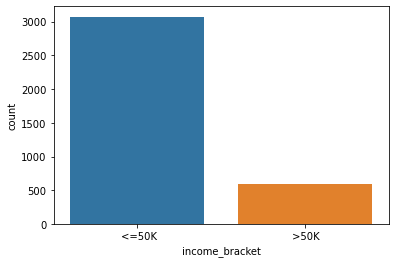

In [27]:
# checking count of income bracket
sns.countplot(x='income_bracket',data=data_clean)

The data shows that more people have income bracket below 50k that above. This may somewhat affect the model result.

<AxesSubplot:xlabel='occupation'>

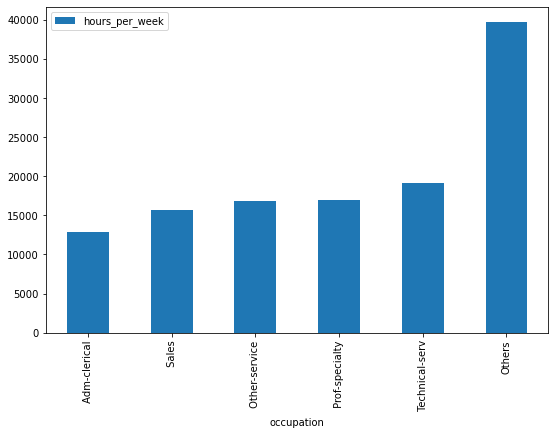

In [28]:
data_clean.groupby('occupation')[['hours_per_week']].sum().sort_values('hours_per_week').plot(kind='bar', figsize=(9,6))

This visualization describes the number of hours worked each week from each occupation. Jobs that use the least working hours each week are Adm-clerical jobs compared to other jobs.

<AxesSubplot:xlabel='education'>

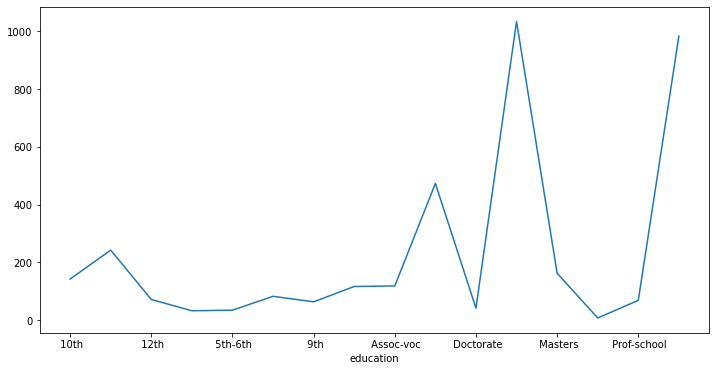

In [29]:
data_clean.groupby('education')['income_bracket'].count().plot(figsize=(12, 6))

Based on this simple visualization that provides information about the income bracket based on education. From the visualization above, it can be concluded that the higher the education level, the higher the income bracket, as the highest income bracket is at the doctorate education level, while the lowest income bracket is at the 5th-6th education level, so it can be said that the income bracket is strongly influenced by education.

## VI. Split data into Train and Test

Separate samples before splitting for later model inference

In [30]:
inference = data_clean.sample(10, random_state=15)
data_clean = data_clean.drop(inference.index)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3658 entries, 2 to 3995
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             3658 non-null   int64   
 1   workclass       3658 non-null   object  
 2   education       3658 non-null   object  
 3   education_num   3658 non-null   int64   
 4   marital_status  3658 non-null   object  
 5   occupation      3658 non-null   object  
 6   relationship    3658 non-null   object  
 7   race            3658 non-null   object  
 8   sex             3658 non-null   object  
 9   capital_gain    3658 non-null   int64   
 10  capital_loss    3658 non-null   int64   
 11  hours_per_week  3658 non-null   int64   
 12  native_country  3658 non-null   object  
 13  income_bracket  3658 non-null   category
dtypes: category(1), int64(5), object(8)
memory usage: 403.8+ KB


Determine between feature and target. it can be seen in this case that the target is in the income_bracket column and we can set it as the y variable, while in addition to the income_bracket column we can set it to the x variable.

In [31]:
# define feature and target
X = data_clean.drop('income_bracket', axis=1)
y = data_clean['income_bracket']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [32]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(2560, 13)
(1098, 13)
(2560,)
(1098,)


See the shape between X and Y of each train and test. This means that the data distribution is 70% for the train data and 30% for the test data from the cleaned data (`data_clean`) so that the train has a shape of 2560 rows and the test has 1098 rows.

In [33]:
# for EDA model creation, use dataframe stored in data_eda
data_eda = pd.concat([X_train, y_train], axis=1)

data_eda.shape

(2560, 14)

Merge from X and Y that we have separated, but which are merged only for train data only. The data for testing is different when the preprocessing data is from the train data

## VII. EDA FOR MODELING

In [34]:
data_eda.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
2544,56,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,15,United-States,<=50K
1751,32,Private,Some-college,10,Divorced,Others,Not-in-family,White,Female,0,1590,54,United-States,<=50K
2734,46,Private,HS-grad,9,Married-civ-spouse,Other-service,Own-child,White,Female,0,0,15,United-States,<=50K
1058,47,Private,HS-grad,9,Divorced,Other-service,Not-in-family,White,Female,0,0,4,United-States,<=50K
3461,43,Self-emp,HS-grad,9,Married-civ-spouse,Technical-serv,Husband,White,Male,0,0,20,United-States,<=50K


In [35]:
# get name columns for data type numeric and categoric
num_col = data_eda.select_dtypes(exclude=['object']).columns.tolist()
cat_col = data_eda.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns   : ', num_col)
print('Categorical Columns : ', cat_col)

Numerical Columns   :  ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'income_bracket']
Categorical Columns :  ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


We separate first for numeric data with categorical data, for numeric data there are 6 columns and for categorical data there are 8 columns

In [36]:
data_eda[num_col].shape

(2560, 6)

In [37]:
data_eda[cat_col].shape

(2560, 8)

### **categorical features**

encoding income bracket as the target column

In [38]:
# encoding income bracket
data_eda['income_bracket_en']=data_eda['income_bracket'].cat.codes
data_eda.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,income_bracket_en
2544,56,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,15,United-States,<=50K,0
1751,32,Private,Some-college,10,Divorced,Others,Not-in-family,White,Female,0,1590,54,United-States,<=50K,0
2734,46,Private,HS-grad,9,Married-civ-spouse,Other-service,Own-child,White,Female,0,0,15,United-States,<=50K,0
1058,47,Private,HS-grad,9,Divorced,Other-service,Not-in-family,White,Female,0,0,4,United-States,<=50K,0
3461,43,Self-emp,HS-grad,9,Married-civ-spouse,Technical-serv,Husband,White,Male,0,0,20,United-States,<=50K,0


In [39]:
# save in data_cat process as temporary variable
data_cat = data_eda[cat_col + ['income_bracket_en']]

data_cat.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income_bracket_en
2544,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,United-States,0
1751,Private,Some-college,Divorced,Others,Not-in-family,White,Female,United-States,0
2734,Private,HS-grad,Married-civ-spouse,Other-service,Own-child,White,Female,United-States,0
1058,Private,HS-grad,Divorced,Other-service,Not-in-family,White,Female,United-States,0
3461,Self-emp,HS-grad,Married-civ-spouse,Technical-serv,Husband,White,Male,United-States,0


Before encoding all column categories, we will check the correlation between features and targets using chi-squared

In [40]:
# Checking correlation between income bracket and workclass

# Defining hypothesis
# H0= workclass and income bracket are unrelated
# Ha= workclass and income bracket are related

#creating a contingency table
ct=pd.crosstab(data_eda["workclass"],data_eda["income_bracket"])
# checking the dependency of income bracket and occupation
stat, p, dof, expected = stats.chi2_contingency(ct)
print(ct)
print('p=%.12f' %(p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

income_bracket   <=50K   >50K
workclass                    
 Government        313     81
 Private          1546    238
 Self-emp          287     95
p=0.000000007361
Probably dependent


In [41]:
# Checking correlation between income bracket and education

# Defining hypothesis
# H0= education and income bracket are unrelated
# Ha= education and income bracket are related

#creating a contingency table
ct=pd.crosstab(data_eda["education"],data_eda["income_bracket"])
# checking the dependency of income bracket and occupation
stat, p, dof, expected = stats.chi2_contingency(ct)
print(ct)
print('p=%.12f' %(p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

income_bracket   <=50K   >50K
education                    
 10th               92      4
 11th              166      1
 12th               46      1
 1st-4th            22      2
 5th-6th            23      1
 7th-8th            49      3
 9th                41      1
 Assoc-acdm         66     13
 Assoc-voc          66     18
 Bachelors         239     88
 Doctorate          11     18
 HS-grad           626     98
 Masters            66     43
 Preschool           6      0
 Prof-school        22     28
 Some-college      605     95
p=0.000000000000
Probably dependent


In [42]:
# Checking correlation between income bracket and marital_status

# Defining hypothesis
# H0= marital_status and income bracket are unrelated
# Ha= marital_status and income bracket are related

#creating a contingency table
ct=pd.crosstab(data_cat["marital_status"],data_cat["income_bracket_en"])
# checking the dependency of income bracket and occupation
stat, p, dof, expected = stats.chi2_contingency(ct)
print(ct)
print('p=%.12f' %(p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

income_bracket_en          0    1
marital_status                   
 Divorced                278   28
 Married-AF-spouse         2    0
 Married-civ-spouse      555  344
 Married-spouse-absent    31    5
 Never-married          1068   26
 Separated                73    3
 Widowed                 139    8
p=0.000000000000
Probably dependent


In [43]:
# Checking correlation between income bracket and occupation

# Defining hypothesis
# H0= occupation and income bracket are unrelated
# Ha= occupation and income bracket are related

#creating a contingency table
ct=pd.crosstab(data_cat["occupation"],data_cat["income_bracket_en"])
# checking the dependency of income bracket and occupation
stat, p, dof, expected = stats.chi2_contingency(ct)
print(ct)
print('p=%.12f' %(p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

income_bracket_en    0    1
occupation                 
 Adm-clerical      344   28
 Other-service     444   15
 Prof-specialty    267   97
 Sales             326   51
 Technical-serv    300   68
Others             465  155
p=0.000000000000
Probably dependent


In [44]:
# Checking correlation between income bracket and relationship

# Defining hypothesis
# H0= relationship and income bracket are unrelated
# Ha= relationship and income bracket are related

#creating a contingency table
ct=pd.crosstab(data_cat["relationship"],data_cat["income_bracket_en"])
# checking the dependency of income bracket and occupation
stat, p, dof, expected = stats.chi2_contingency(ct)
print(ct)
print('p=%.12f' %(p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

income_bracket_en    0    1
relationship               
 Husband           457  282
 Not-in-family     590   56
 Other-relative     85    2
 Own-child         670    1
 Unmarried         260   13
 Wife               84   60
p=0.000000000000
Probably dependent


In [45]:
# Checking correlation between income bracket and race

# Defining hypothesis
# H0= race and income bracket are unrelated
# Ha= race and income bracket are related

#creating a contingency table
ct=pd.crosstab(data_cat["race"],data_cat["income_bracket_en"])
# checking the dependency of income bracket and occupation
stat, p, dof, expected = stats.chi2_contingency(ct)
print(ct)
print('p=%.12f' %(p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

income_bracket_en       0    1
race                          
 Amer-Indian-Eskimo    21    1
 Asian-Pac-Islander    59   17
 Black                216   22
 Other                 16    0
 White               1834  374
p=0.002098000965
Probably dependent


In [46]:
# Checking correlation between income bracket and sex

# Defining hypothesis
# H0= sex and income bracket are unrelated
# Ha= sex and income bracket are related

#creating a contingency table
ct=pd.crosstab(data_cat["sex"],data_cat["income_bracket_en"])
# checking the dependency of income bracket and occupation
stat, p, dof, expected = stats.chi2_contingency(ct)
print(ct)
print('p=%.12f' %(p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

income_bracket_en     0    1
sex                         
 Female            1026   91
 Male              1120  323
p=0.000000000000
Probably dependent


In [47]:
# Checking correlation between income bracket and native_country

# Defining hypothesis
# H0= native_country and income bracket are unrelated
# Ha= native_country and income bracket are related

#creating a contingency table
ct=pd.crosstab(data_cat["native_country"],data_cat["income_bracket_en"])
# checking the dependency of income bracket and occupation
stat, p, dof, expected = stats.chi2_contingency(ct)
print(ct)
print('p=%.12f' %(p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

income_bracket_en               0    1
native_country                        
 Canada                         7    4
 China                          3    2
 Columbia                       2    0
 Cuba                           7    2
 Dominican-Republic             8    1
 Ecuador                        3    0
 El-Salvador                   10    0
 England                        7    4
 France                         2    1
 Germany                        9    3
 Greece                         3    0
 Guatemala                      1    0
 Haiti                          4    1
 Honduras                       1    0
 Hungary                        4    0
 India                          7    4
 Iran                           2    0
 Italy                          6    2
 Jamaica                        4    0
 Japan                          3    3
 Mexico                        46    3
 Nicaragua                      1    0
 Outlying-US(Guam-USVI-etc)     1    0
 Peru                    

Based on the results of the chi-squared above, it can be seen that in all columns the results are probably dependent, which means that there is a correlation between the feature and the target except for the native_country column so that in native_country we will not do encoding.

**One Hot Encoding for `workclass`, `occupation`, `relationship`,`sex`, `race`, and `marital_status`**

In [48]:
data_cat[['workclass', 'occupation', 'relationship','sex', 'race', 'marital_status']].head(5)

,workclass,occupation,relationship,sex,race,marital_status
2544,Private,Sales,Wife,Female,White,Married-civ-spouse
1751,Private,Others,Not-in-family,Female,White,Divorced
2734,Private,Other-service,Own-child,Female,White,Married-civ-spouse
1058,Private,Other-service,Not-in-family,Female,White,Divorced
3461,Self-emp,Technical-serv,Husband,Male,White,Married-civ-spouse


In [49]:
ohe_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

cat_ohe = pd.DataFrame(ohe_enc.fit_transform(data_cat[['workclass', 'occupation', 'relationship','sex', 'race', 'marital_status']]))
cat_ohe.columns = ohe_enc.get_feature_names(['workclass', 'occupation', 'relationship','sex', 'race', 'marital_status'])

cat_ohe.head()

,workclass_ Government,workclass_ Private,workclass_ Self-emp,occupation_ Adm-clerical,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Sales,occupation_ Technical-serv,occupation_Others,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [50]:
ohe_corr = pd.concat([data_cat['income_bracket_en'].reset_index(drop=True), cat_ohe], axis=1)
ohe_corr.head()

,income_bracket_en,workclass_ Government,workclass_ Private,workclass_ Self-emp,occupation_ Adm-clerical,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Sales,occupation_ Technical-serv,occupation_Others,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed
0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


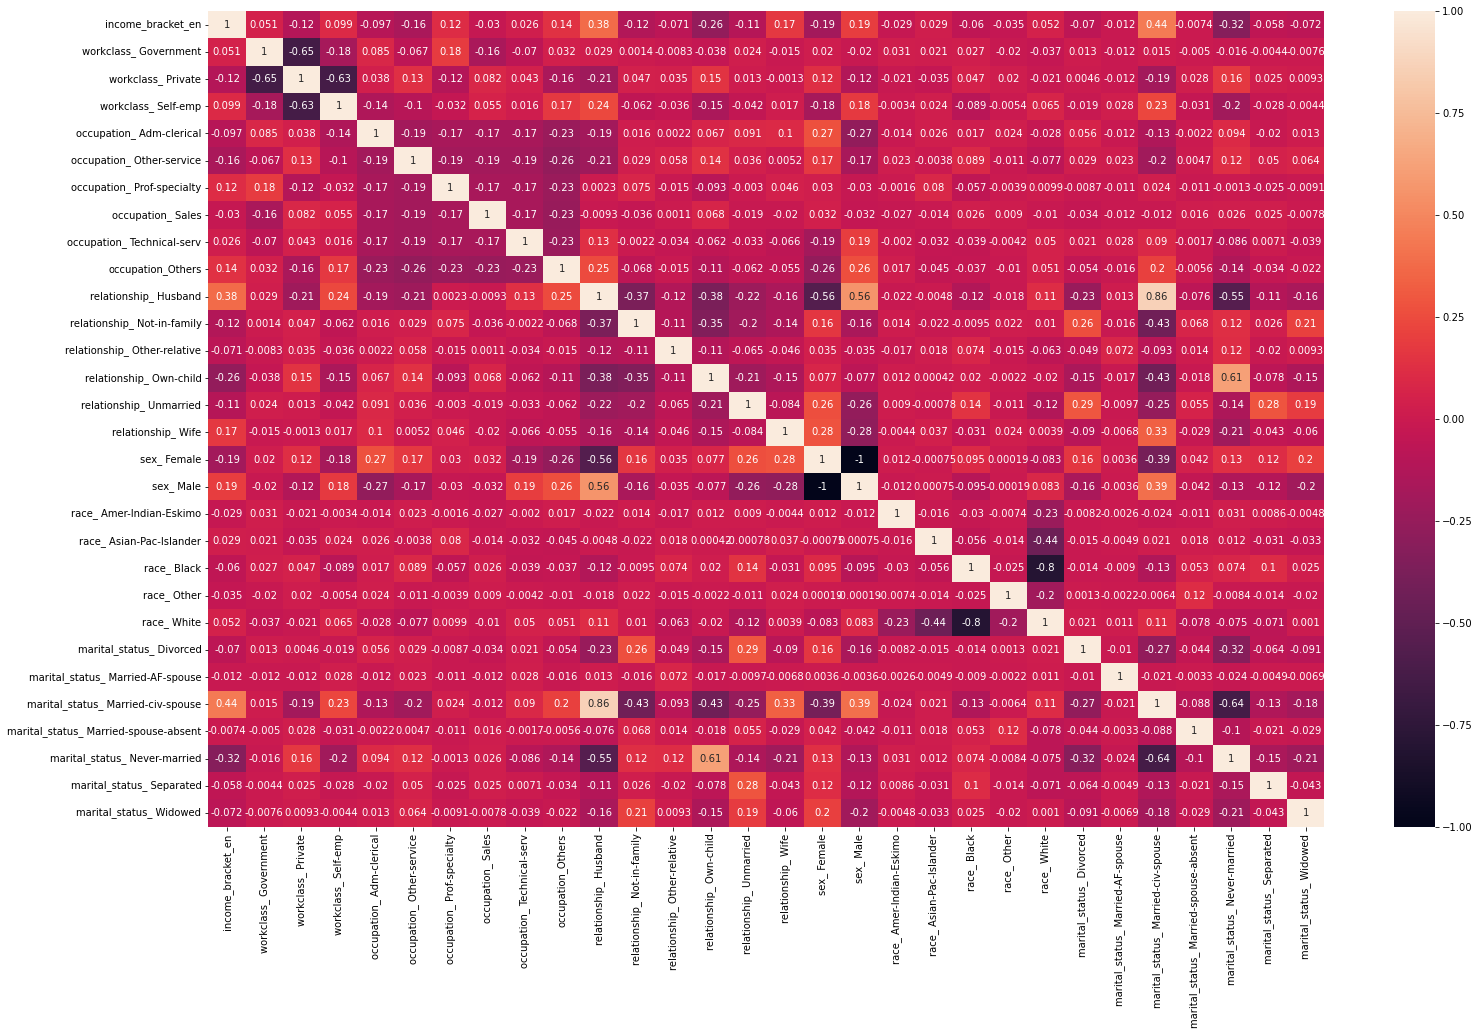

In [51]:
fig,ax = plt.subplots(figsize=[25,15])

corr = ohe_corr.corr()

ax = sns.heatmap(corr,annot=True)
plt.show()

Based on the correlation heatmap above, we can do feature selection by taking features with values ​​greater than +0.1 and -0.1 .

In [52]:
ohe_corr.head()

,income_bracket_en,workclass_ Government,workclass_ Private,workclass_ Self-emp,occupation_ Adm-clerical,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Sales,occupation_ Technical-serv,occupation_Others,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed
0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [53]:
data_cat_clean = ohe_corr.drop(['marital_status_ Widowed', 'marital_status_ Separated', 'marital_status_ Married-spouse-absent', 'marital_status_ Married-AF-spouse', 
            'marital_status_ Divorced', 'race_ White', 'race_ Other', 'race_ Black', 'race_ Asian-Pac-Islander', 'race_ Amer-Indian-Eskimo',
            'relationship_ Other-relative', 'occupation_ Technical-serv', 'occupation_ Sales', 'occupation_ Adm-clerical', 'workclass_ Government', 'sex_ Female'], axis=1)

data_cat_clean.head()

,income_bracket_en,workclass_ Private,workclass_ Self-emp,occupation_ Other-service,occupation_ Prof-specialty,occupation_Others,relationship_ Husband,relationship_ Not-in-family,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male,marital_status_ Married-civ-spouse,marital_status_ Never-married
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


**Ordinal Encoder for `education`**

In [54]:
for i in ['education']:
    print(data_cat[i].value_counts())
    print('-'*30)

 HS-grad         724
 Some-college    700
 Bachelors       327
 11th            167
 Masters         109
 10th             96
 Assoc-voc        84
 Assoc-acdm       79
 7th-8th          52
 Prof-school      50
 12th             47
 9th              42
 Doctorate        29
 5th-6th          24
 1st-4th          24
 Preschool         6
Name: education, dtype: int64
------------------------------


In [55]:
education_cat = [' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th', ' HS-grad', 
                ' Prof-school', ' Assoc-acdm', ' Assoc-voc', ' Some-college', ' Bachelors', ' Masters', ' Doctorate']

ord_enc = OrdinalEncoder(categories=[education_cat])
cat_ord = pd.DataFrame(ord_enc.fit_transform(data_cat[['education']]))

cat_ord.columns = ['education']
review = pd.concat([data_cat[['education']].reset_index(drop=True), cat_ord], axis=1)

review.head()

,education,education
0,HS-grad,8.0
1,Some-college,12.0
2,HS-grad,8.0
3,HS-grad,8.0
4,HS-grad,8.0


In [56]:
data_cat_clean = pd.concat([data_cat_clean.reset_index(drop=True), cat_ord], axis=1)
data_cat_clean.head()

,income_bracket_en,workclass_ Private,workclass_ Self-emp,occupation_ Other-service,occupation_ Prof-specialty,occupation_Others,relationship_ Husband,relationship_ Not-in-family,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male,marital_status_ Married-civ-spouse,marital_status_ Never-married,education
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0
1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
2,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8.0
3,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,8.0


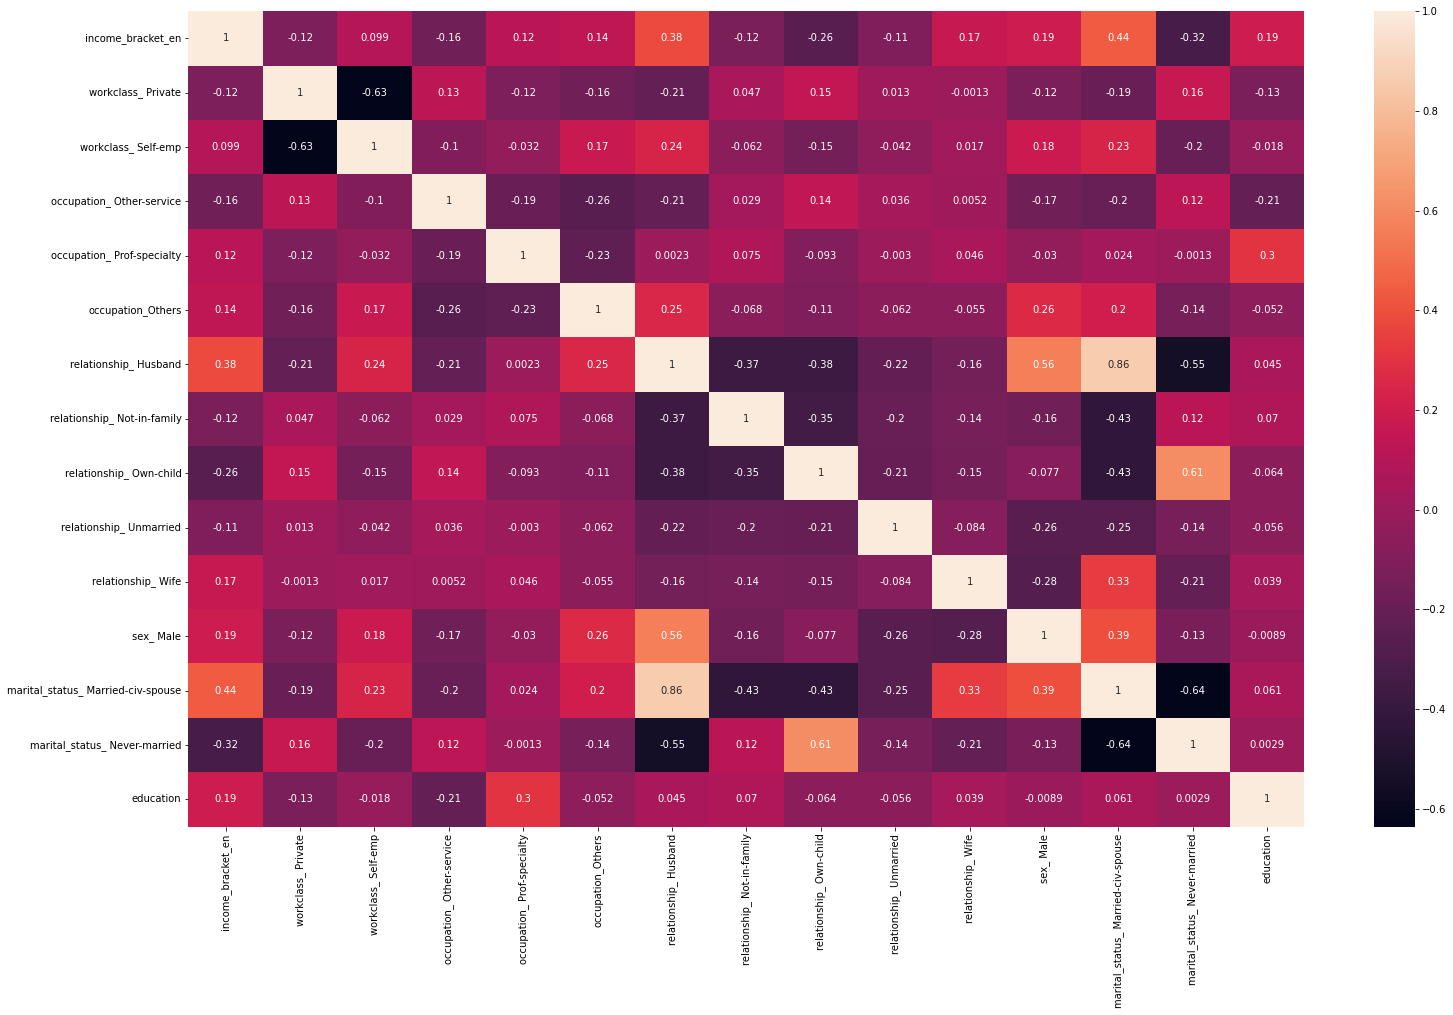

In [57]:
fig,ax = plt.subplots(figsize=[25,15])

corr = data_cat_clean.corr()

ax = sns.heatmap(corr,annot=True)
plt.show()

After encoding the entire categorical column, we can see the correlation of each of these features to the target. Based on the heatmap above, the correlation value of education to income_bracket includes a high correlation value

### **numerical feature**

After we fully encode categorical data, then we focus on preprocessing numerical data

In [58]:
data_eda[num_col].head()

,age,education_num,capital_gain,capital_loss,hours_per_week,income_bracket
2544,56,9,0,0,15,<=50K
1751,32,10,0,1590,54,<=50K
2734,46,9,0,0,15,<=50K
1058,47,9,0,0,4,<=50K
3461,43,9,0,0,20,<=50K


In [59]:
def plot_dist(data_eda, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

# histogram
    sns.histplot(data_eda[col],ax = axes[0], bins=30)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(data_eda[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(data_eda[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()

# boxplot
    if data_eda[col].skew() >= 1 or data_eda[col].skew() <= -1 :
        sns.boxplot(y=data_eda[col], ax =  axes[1], whis=3)
        axes[1].set_title(f"Boxplot '{col}'")
    
        plt.show()
    else:
        sns.boxplot(y=data_eda[col], ax =  axes[1], whis=1.5)
        axes[1].set_title(f"Boxplot '{col}'")
    
        plt.show()
        
# skewness
    print(data_eda[col].name + ' Skewness: ' + str(data_eda[col].skew()))
    if -0.5 <= data_eda[col].skew() <= 0.5:
        print("Columns '{}' normal distribution".format(col))
    elif data_eda[col].skew() > 0.5:
        print("Columns '{}' right skewed".format(col))
    elif data_eda[col].skew() < -0.5:
        print("Columns '{}' left skewed".format(col))

Create a function to determine the distribution and skew detection of each column in numeric data

#### Age

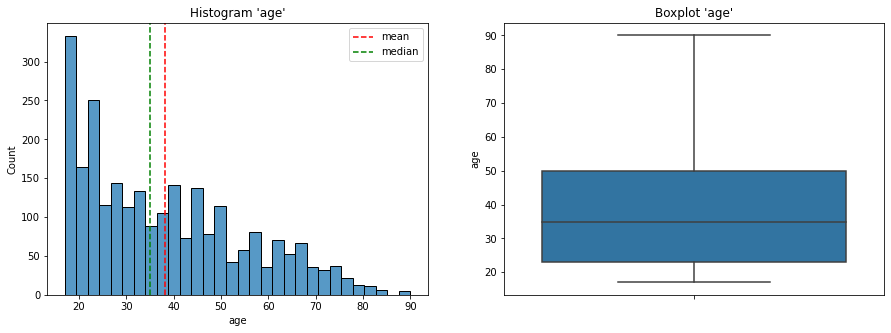

age Skewness: 0.6553526645233008
Columns 'age' right skewed


In [60]:
# checking the distribution of age
plot_dist(data_eda, 'age')

In [61]:
# outlier detection using IQR 
Q3 = data_eda['age'].quantile(.75)
Q1 = data_eda['age'].quantile(.25)

IQR = Q3 - Q1

upper = Q3 + (1.5 * IQR)
lower = Q1 - (1.5 * IQR)

outlier = data_eda[(data_eda['age'] > upper) | (data_eda['age'] < lower)]

print('count of outlier: ', outlier.shape[0])
print('percentage of outlier: ', outlier.shape[0]/data_eda.shape[0] * 100, '%')

count of outlier:  0
percentage of outlier:  0.0 %


#### Education_num

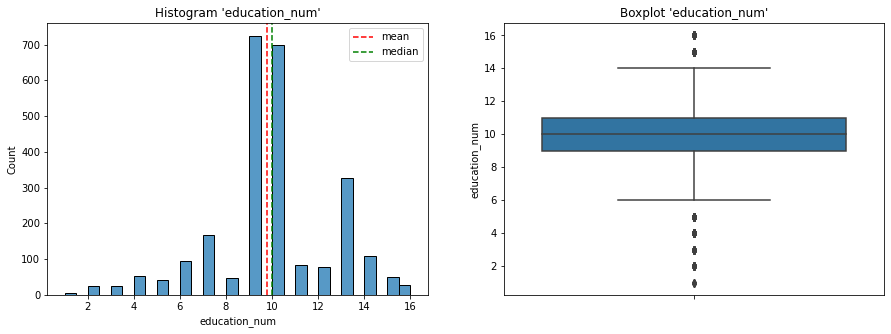

education_num Skewness: -0.2834679486903808
Columns 'education_num' normal distribution


In [62]:
# checking the distribution of education_num
plot_dist(data_eda, 'education_num')

In [63]:
# outlier detection for normal distribution
outliers_L = (data_eda.education_num.mean()) - (3 * (data_eda.education_num.std()))
outliers_R = (data_eda.education_num.mean()) + (3 * (data_eda.education_num.std()))

outlier = data_eda[(data_eda['education_num'] > outliers_R) | (data_eda['education_num'] < outliers_L)]

print('count of outlier: ', outlier.shape[0])
print('percentage of outlier: ', outlier.shape[0]/data_eda.shape[0] * 100, '%')

count of outlier:  6
percentage of outlier:  0.234375 %


In [64]:
# capping outlier
wins = Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=['education_num'])

data_num_cleaned = wins.fit_transform(data_eda)

#### Capital_gain

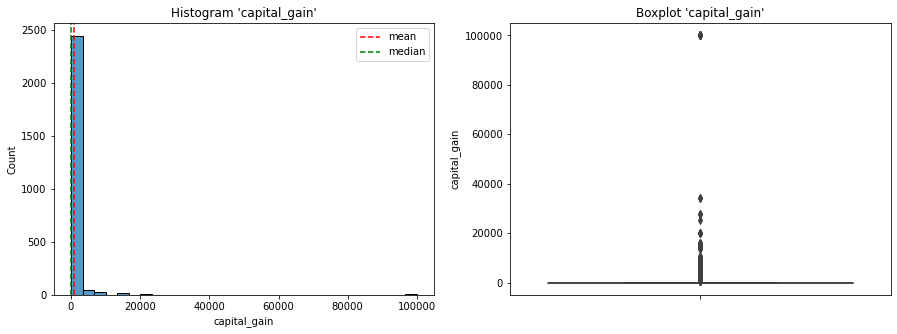

capital_gain Skewness: 13.390079199509636
Columns 'capital_gain' right skewed


In [65]:
# checking the distribution of capital_gain
plot_dist(data_num_cleaned, 'capital_gain')

In [66]:
# outlier detection using IQR 
Q3 = data_num_cleaned['capital_gain'].quantile(.75)
Q1 = data_num_cleaned['capital_gain'].quantile(.25)

IQR = Q3 - Q1

upper = Q3 + (3 * IQR)
lower = Q1 - (3 * IQR)

outlier = data_num_cleaned[(data_num_cleaned['capital_gain'] > upper) | (data_num_cleaned['capital_gain'] < lower)]

print('count of outlier: ', outlier.shape[0])
print('percentage of outlier: ', outlier.shape[0]/data_num_cleaned.shape[0] * 100, '%')

count of outlier:  180
percentage of outlier:  7.03125 %


#### Capital_loss

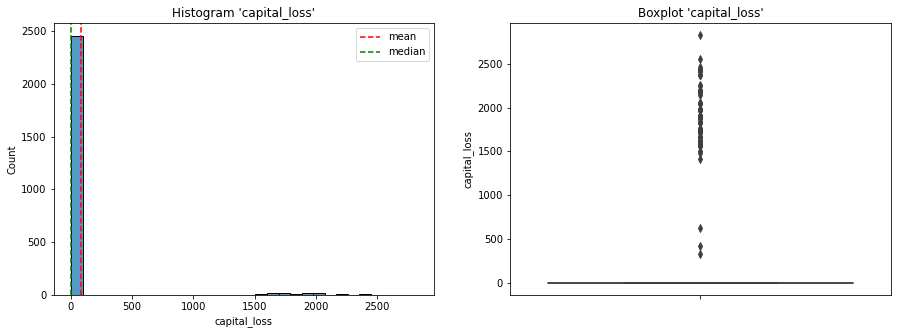

capital_loss Skewness: 4.81066758364994
Columns 'capital_loss' right skewed


In [67]:
# checking the distribution of capital_loss
plot_dist(data_num_cleaned, 'capital_loss')

In [68]:
# outlier detection using IQR 
Q3 = data_num_cleaned['capital_loss'].quantile(.75)
Q1 = data_num_cleaned['capital_loss'].quantile(.25)

IQR = Q3 - Q1

upper = Q3 + (3 * IQR)
lower = Q1 - (3 * IQR)

outlier = data_num_cleaned[(data_num_cleaned['capital_loss'] > upper) | (data_num_cleaned['capital_loss'] < lower)]

print('count of outlier: ', outlier.shape[0])
print('percentage of outlier: ', outlier.shape[0]/data_num_cleaned.shape[0] * 100, '%')

count of outlier:  108
percentage of outlier:  4.21875 %


#### Hours_per_week

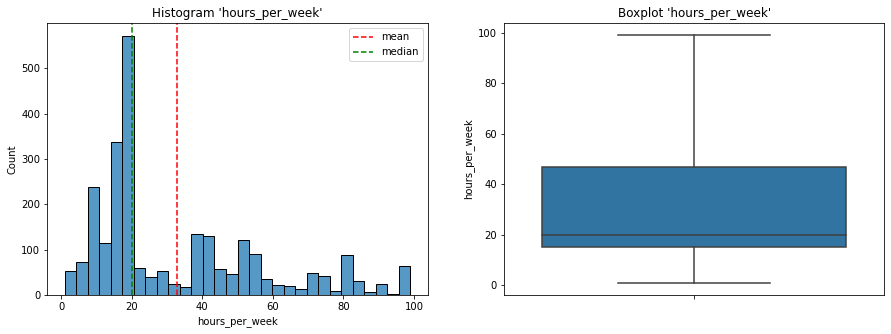

hours_per_week Skewness: 1.0455514050910364
Columns 'hours_per_week' right skewed


In [69]:
# checking the distribution of hours_per_week
plot_dist(data_num_cleaned, 'hours_per_week')

In [70]:
# outlier detection using IQR 
Q3 = data_num_cleaned['hours_per_week'].quantile(.75)
Q1 = data_num_cleaned['hours_per_week'].quantile(.25)

IQR = Q3 - Q1

upper = Q3 + (3 * IQR)
lower = Q1 - (3 * IQR)

outlier = data_num_cleaned[(data_num_cleaned['hours_per_week'] > upper) | (data_num_cleaned['hours_per_week'] < lower)]

print('count of outlier: ', outlier.shape[0])
print('percentage of outlier: ', outlier.shape[0]/data_num_cleaned.shape[0] * 100, '%')

count of outlier:  0
percentage of outlier:  0.0 %


Based on the analysis above, we can see that for handling outliers numerical data is only done on the education_num feature by using the gaussian capping method and for other features no outliers are detected. The capital gain and capital loss columns are not handled with outliers even though outliers are detected because the column explains the gains or losses obtained from the sale of assets or other investments. If we look at Q3 and Q1 which are 0 and if we handle the outliers using the capping method, it doesn't make sense for data that should have capital gains and capital losses but are capped using the upper or lower so that the outliers detected in this case are thought to be not. is part of the outliers.

In [71]:
# Compare before and after outlier handling
print('before handling: \n', data_eda[num_col].describe())

print('after handling: \n', data_num_cleaned[num_col].describe())

before handling: 
                age  education_num  capital_gain  capital_loss  hours_per_week
count  2560.000000    2560.000000   2560.000000   2560.000000     2560.000000
mean     38.152734       9.782813    835.628516     77.989063       32.935156
std      17.024467       2.602434   6630.773141    379.350073       24.338816
min      17.000000       1.000000      0.000000      0.000000        1.000000
25%      23.000000       9.000000      0.000000      0.000000       15.000000
50%      35.000000      10.000000      0.000000      0.000000       20.000000
75%      50.000000      11.000000      0.000000      0.000000       47.000000
max      90.000000      16.000000  99999.000000   2824.000000       99.000000
after handling: 
                age  education_num  capital_gain  capital_loss  hours_per_week
count  2560.000000    2560.000000   2560.000000   2560.000000     2560.000000
mean     38.152734       9.785102    835.628516     77.989063       32.935156
std      17.024467       2.

In [72]:
data_num_cleaned.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,income_bracket_en
2544,56,Private,HS-grad,9.0,Married-civ-spouse,Sales,Wife,White,Female,0,0,15,United-States,<=50K,0
1751,32,Private,Some-college,10.0,Divorced,Others,Not-in-family,White,Female,0,1590,54,United-States,<=50K,0
2734,46,Private,HS-grad,9.0,Married-civ-spouse,Other-service,Own-child,White,Female,0,0,15,United-States,<=50K,0
1058,47,Private,HS-grad,9.0,Divorced,Other-service,Not-in-family,White,Female,0,0,4,United-States,<=50K,0
3461,43,Self-emp,HS-grad,9.0,Married-civ-spouse,Technical-serv,Husband,White,Male,0,0,20,United-States,<=50K,0


**combine Numerical and Categorical data after processed**

In [73]:
data_eda_cleaned = pd.concat([data_num_cleaned[num_col].reset_index(drop=True), data_cat_clean.reset_index(drop=True)], axis=1)
data_eda_cleaned.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,income_bracket,income_bracket_en,workclass_ Private,workclass_ Self-emp,occupation_ Other-service,occupation_ Prof-specialty,occupation_Others,relationship_ Husband,relationship_ Not-in-family,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male,marital_status_ Married-civ-spouse,marital_status_ Never-married,education
0,56,9.0,0,0,15,<=50K,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0
1,32,10.0,0,1590,54,<=50K,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
2,46,9.0,0,0,15,<=50K,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8.0
3,47,9.0,0,0,4,<=50K,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,43,9.0,0,0,20,<=50K,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,8.0


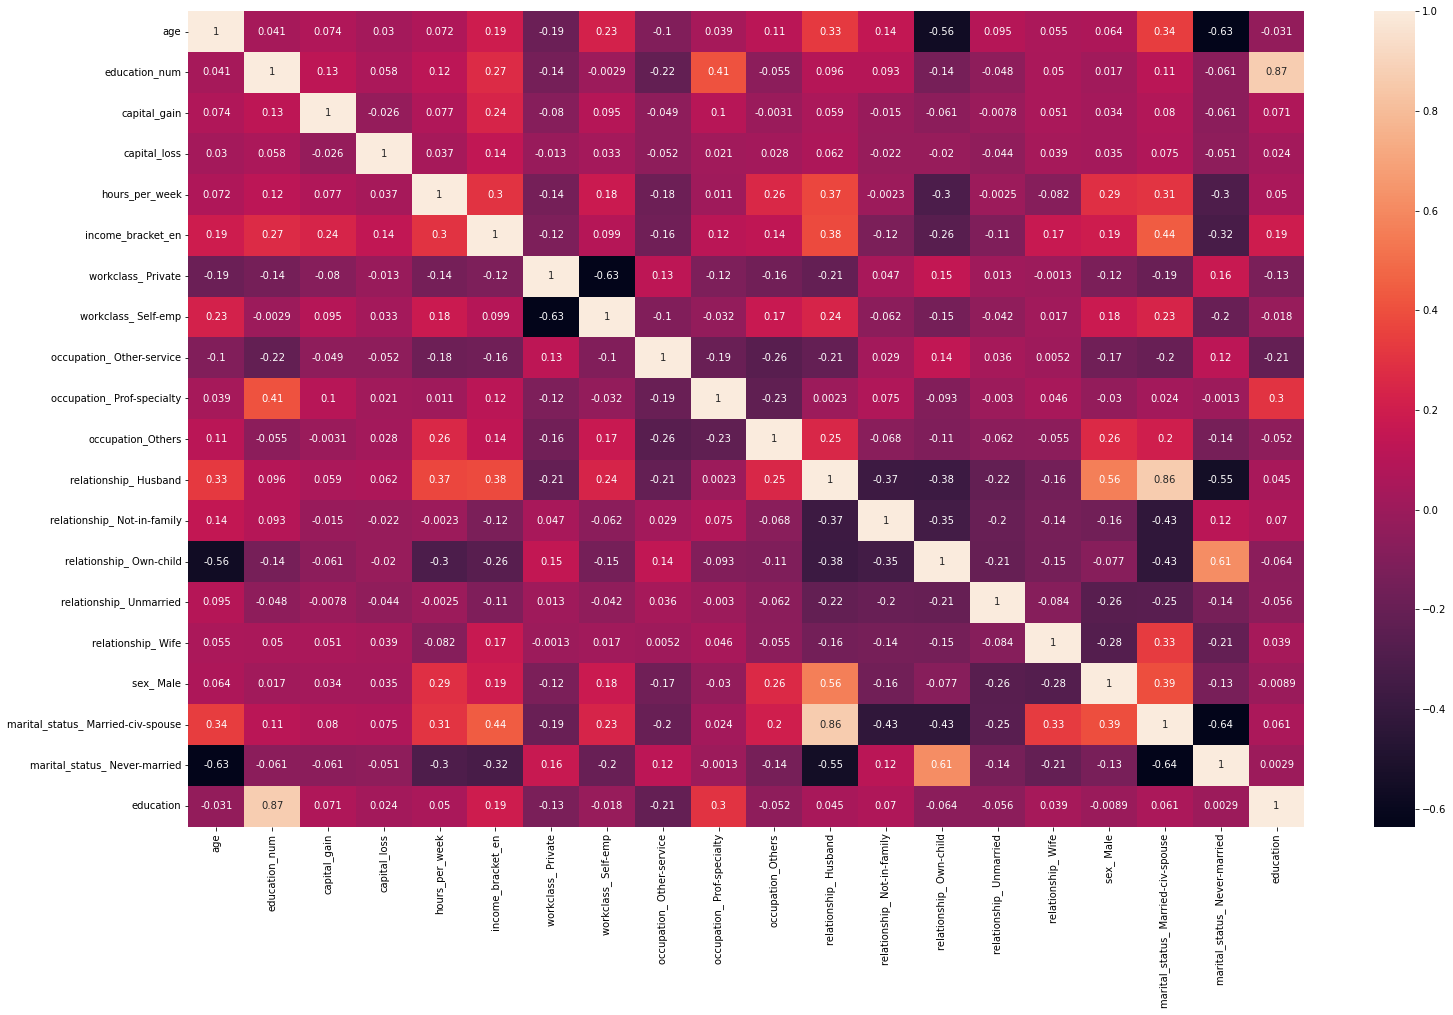

In [74]:
fig,ax = plt.subplots(figsize=[25,15])

corr = data_eda_cleaned.corr()

ax = sns.heatmap(corr,annot=True)
plt.show()

Based on the correlation heatmap above, we can do feature selection by taking features with values ​​greater than +0.2 and -0.2 .

In [75]:
data_eda_cleaned.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,income_bracket,income_bracket_en,workclass_ Private,workclass_ Self-emp,occupation_ Other-service,occupation_ Prof-specialty,occupation_Others,relationship_ Husband,relationship_ Not-in-family,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male,marital_status_ Married-civ-spouse,marital_status_ Never-married,education
0,56,9.0,0,0,15,<=50K,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0
1,32,10.0,0,1590,54,<=50K,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
2,46,9.0,0,0,15,<=50K,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8.0
3,47,9.0,0,0,4,<=50K,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,43,9.0,0,0,20,<=50K,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,8.0


In [76]:
data_eda_cleaned[['income_bracket', 'income_bracket_en', 'marital_status_ Married-civ-spouse', 'marital_status_ Never-married', 
                'relationship_ Own-child', 'relationship_ Husband', 'hours_per_week', 'capital_gain', 'education_num']].head()

,income_bracket,income_bracket_en,marital_status_ Married-civ-spouse,marital_status_ Never-married,relationship_ Own-child,relationship_ Husband,hours_per_week,capital_gain,education_num
0,<=50K,0,1.0,0.0,0.0,0.0,15,0,9.0
1,<=50K,0,0.0,0.0,0.0,0.0,54,0,10.0
2,<=50K,0,1.0,0.0,1.0,0.0,15,0,9.0
3,<=50K,0,0.0,0.0,0.0,0.0,4,0,9.0
4,<=50K,0,1.0,0.0,0.0,1.0,20,0,9.0


After feature selection is done, then we will feature scaling for numerical data

In [77]:
norm = 0
nonorm = 0
for col in data_eda_cleaned[['hours_per_week', 'capital_gain', 'education_num']]:
  if data_eda_cleaned[col].skew() >=-0.5 and data_eda_cleaned[col].skew() <0.5:
    norm += 1
  else:
    nonorm +=1

if norm > nonorm:
  scaler = StandardScaler()
else:
  scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [78]:
# numerical scaling

num_col = ['hours_per_week', 'capital_gain', 'education_num']
scaler = MinMaxScaler()

num_scaled = pd.DataFrame(scaler.fit_transform(data_eda_cleaned[num_col]))
num_scaled.columns = num_col

data_eda_cleaned.drop(num_col, axis=1, inplace=True)
data_eda_cleaned = pd.concat([data_eda_cleaned, num_scaled], axis=1)

data_eda_cleaned = data_eda_cleaned[['income_bracket_en', 'marital_status_ Married-civ-spouse', 'marital_status_ Never-married', 
                                 'relationship_ Own-child', 'relationship_ Husband', 'hours_per_week', 'capital_gain', 'education_num']]

In [79]:
data_eda_cleaned.head()

,income_bracket_en,marital_status_ Married-civ-spouse,marital_status_ Never-married,relationship_ Own-child,relationship_ Husband,hours_per_week,capital_gain,education_num
0,0,1.0,0.0,0.0,0.0,0.142857,0.0,0.500819
1,0,0.0,0.0,0.0,0.0,0.540816,0.0,0.572130
2,0,1.0,0.0,1.0,0.0,0.142857,0.0,0.500819
3,0,0.0,0.0,0.0,0.0,0.030612,0.0,0.500819
4,0,1.0,0.0,0.0,1.0,0.193878,0.0,0.500819


0 itu <=50k
1 >50k

1. Category codes for income bracket
2. Using One Hot Encoding method to `workclass`, `occupation`, `relationship`,`sex`, `race`, `marital_status` columns
3. Using Ordinal Encoder method to `education`
4. Outlier handling in education_num column with capping method or winsorizer
5. Feature Selection -> `income_bracket_en`, `marital_status_ Married-civ-spouse`, `marital_status_ Never-married`, 
                        `relationship_ Own-child`, `relationship_ Husband`, `hours_per_week`, `capital_gain`, `education_num`
6. Scaling on numerical features

## VIII. Data Preprocessing

1. Category codes for income bracket
2. Using One Hot Encoding method to `workclass`, `occupation`, `relationship`,`sex`, `race`, `marital_status` columns
3. Using Ordinal Encoder method to `education`
4. Outlier handling in education_num column with capping method or winsorizer
5. Feature Selection -> `income_bracket_en`, `marital_status_ Married-civ-spouse`, `marital_status_ Never-married`, 
                         `relationship_ Own-child`, `relationship_ Husband`, `hours_per_week`, `capital_gain`, `education_num`
6. Scaling on numerical features

Next we will do testing modeling on the test data that we have separated at the beginning.

In [80]:
testing = pd.concat([X_test, y_test], axis=1)
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 3468 to 2344
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             1098 non-null   int64   
 1   workclass       1098 non-null   object  
 2   education       1098 non-null   object  
 3   education_num   1098 non-null   int64   
 4   marital_status  1098 non-null   object  
 5   occupation      1098 non-null   object  
 6   relationship    1098 non-null   object  
 7   race            1098 non-null   object  
 8   sex             1098 non-null   object  
 9   capital_gain    1098 non-null   int64   
 10  capital_loss    1098 non-null   int64   
 11  hours_per_week  1098 non-null   int64   
 12  native_country  1098 non-null   object  
 13  income_bracket  1098 non-null   category
dtypes: category(1), int64(5), object(8)
memory usage: 121.3+ KB


In [81]:
# encoding income bracket
testing['income_bracket_en']=testing['income_bracket'].cat.codes
testing.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,income_bracket_en
3468,43,Self-emp,Some-college,10,Married-civ-spouse,Technical-serv,Husband,White,Male,0,0,20,United-States,<=50K,0
205,41,Self-emp,Masters,14,Divorced,Sales,Unmarried,White,Male,0,0,5,United-States,>50K,1
2984,22,Private,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,<=50K,0
3394,51,Private,Bachelors,13,Never-married,Adm-clerical,Unmarried,White,Male,0,0,20,United-States,<=50K,0
1056,31,Private,HS-grad,9,Married-spouse-absent,Other-service,Not-in-family,White,Female,0,0,80,Italy,<=50K,0


In [82]:
num_target = num_col + ['income_bracket_en']

print(num_target)
print(cat_col)

['hours_per_week', 'capital_gain', 'education_num', 'income_bracket_en']
['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


In [83]:
# OHE
cat_ohe = pd.DataFrame(ohe_enc.transform(testing[['workclass', 'occupation', 'relationship','sex', 'race', 'marital_status']]))
cat_ohe.columns = ohe_enc.get_feature_names(['workclass', 'occupation', 'relationship','sex', 'race', 'marital_status'])

review = pd.concat([testing[['workclass', 'occupation', 'relationship','sex', 'race', 'marital_status']].reset_index(drop=True), cat_ohe], axis=1)
review.head()

,workclass,occupation,relationship,sex,race,marital_status,workclass_ Government,workclass_ Private,workclass_ Self-emp,occupation_ Adm-clerical,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Sales,occupation_ Technical-serv,occupation_Others,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed
0,Self-emp,Technical-serv,Husband,Male,White,Married-civ-spouse,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Self-emp,Sales,Unmarried,Male,White,Divorced,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Private,Other-service,Own-child,Male,White,Never-married,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Private,Adm-clerical,Unmarried,Male,White,Never-married,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Private,Other-service,Not-in-family,Female,White,Married-spouse-absent,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [84]:
# ordinal encoder
cat_ord = pd.DataFrame(ord_enc.transform(testing[['education']]))

cat_ord.columns = ['education']
review = pd.concat([testing[['education']].reset_index(drop=True), cat_ord], axis=1)

review.head()

,education,education
0,Some-college,12.0
1,Masters,14.0
2,Some-college,12.0
3,Bachelors,13.0
4,HS-grad,8.0


In [85]:
# capping outlier
testing = wins.transform(testing)
testing.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,income_bracket_en
3468,43,Self-emp,Some-college,10.0,Married-civ-spouse,Technical-serv,Husband,White,Male,0,0,20,United-States,<=50K,0
205,41,Self-emp,Masters,14.0,Divorced,Sales,Unmarried,White,Male,0,0,5,United-States,>50K,1
2984,22,Private,Some-college,10.0,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,<=50K,0
3394,51,Private,Bachelors,13.0,Never-married,Adm-clerical,Unmarried,White,Male,0,0,20,United-States,<=50K,0
1056,31,Private,HS-grad,9.0,Married-spouse-absent,Other-service,Not-in-family,White,Female,0,0,80,Italy,<=50K,0


In [86]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 3468 to 2344
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                1098 non-null   int64   
 1   workclass          1098 non-null   object  
 2   education          1098 non-null   object  
 3   education_num      1098 non-null   float64 
 4   marital_status     1098 non-null   object  
 5   occupation         1098 non-null   object  
 6   relationship       1098 non-null   object  
 7   race               1098 non-null   object  
 8   sex                1098 non-null   object  
 9   capital_gain       1098 non-null   int64   
 10  capital_loss       1098 non-null   int64   
 11  hours_per_week     1098 non-null   int64   
 12  native_country     1098 non-null   object  
 13  income_bracket     1098 non-null   category
 14  income_bracket_en  1098 non-null   int8    
dtypes: category(1), float64(1), int64(4), int8(1), objec

In [87]:
testing_cleaned = pd.concat([testing[num_target].reset_index(drop=True), cat_ohe, cat_ord], axis=1)
testing_cleaned = testing_cleaned[['income_bracket_en', 'marital_status_ Married-civ-spouse', 'marital_status_ Never-married',  
                                'relationship_ Own-child', 'relationship_ Husband', 'hours_per_week', 'capital_gain', 'education_num']]

testing_cleaned.head()

,income_bracket_en,marital_status_ Married-civ-spouse,marital_status_ Never-married,relationship_ Own-child,relationship_ Husband,hours_per_week,capital_gain,education_num
0,0,1.0,0.0,0.0,1.0,20,0,10.0
1,1,0.0,0.0,0.0,0.0,5,0,14.0
2,0,0.0,1.0,1.0,0.0,16,0,10.0
3,0,0.0,1.0,0.0,0.0,20,0,13.0
4,0,0.0,0.0,0.0,0.0,80,0,9.0


In [88]:
# numerical scaling

num_col = ['hours_per_week', 'capital_gain', 'education_num']

num_scaled = pd.DataFrame(scaler.transform(testing_cleaned[num_col]))
num_scaled.columns = num_col

testing_cleaned.drop(num_col, axis=1, inplace=True)
testing_cleaned = pd.concat([testing_cleaned, num_scaled], axis=1)
testing_cleaned = testing_cleaned[['income_bracket_en', 'marital_status_ Married-civ-spouse', 'marital_status_ Never-married', 
                                'relationship_ Own-child', 'relationship_ Husband', 'hours_per_week', 'capital_gain', 'education_num']]
testing_cleaned.head()

,income_bracket_en,marital_status_ Married-civ-spouse,marital_status_ Never-married,relationship_ Own-child,relationship_ Husband,hours_per_week,capital_gain,education_num
0,0,1.0,0.0,0.0,1.0,0.193878,0.0,0.572130
1,1,0.0,0.0,0.0,0.0,0.040816,0.0,0.857377
2,0,0.0,1.0,1.0,0.0,0.153061,0.0,0.572130
3,0,0.0,1.0,0.0,0.0,0.193878,0.0,0.786065
4,0,0.0,0.0,0.0,0.0,0.806122,0.0,0.500819


In [89]:
X_train = data_eda_cleaned.drop('income_bracket_en',axis=1).copy()
y_train = data_eda_cleaned['income_bracket_en']

X_test = testing_cleaned.drop('income_bracket_en',axis=1).copy()
y_test = testing_cleaned['income_bracket_en']

## IX. MODEL TRAINING

Define logistic regression model and svm model, and then assign it to a new variable

In [90]:
# defining logistic regression model
# first logistic regression
log_model1 = LogisticRegression(C=1.2,max_iter=1000000)
log_model1.fit(X_train, y_train)

pred_train_log1 = log_model1.predict(X_train)
pred_test_log1 = log_model1.predict(X_test)

# second logistic regression
log_model2 = LogisticRegression(solver='liblinear', random_state=50, max_iter=100000)
log_model2.fit(X_train, y_train)

pred_train_log2 = log_model2.predict(X_train)
pred_test_log2 = log_model2.predict(X_test)

In [91]:
# defining SVM model
# First SVM model
svc_model1 = SVC(kernel='poly', C=0.5, probability=True)
svc_model1.fit(X_train, y_train)

pred_train_svc1 = svc_model1.predict(X_train)
pred_test_svc1 = svc_model1.predict(X_test)

# second SVM model
svc_model2 = SVC(kernel='linear', C=0.8, probability=True)
svc_model2.fit(X_train, y_train)

pred_train_svc2 = svc_model2.predict(X_train)
pred_test_svc2 = svc_model2.predict(X_test)

## X. MODEL EVALUATION

**Logistic Regression**

In [92]:
print("="*20,"TRAINING","="*20)
print(classification_report(y_train,pred_train_log1,zero_division=0))
print("\n")
print("="*23,"TEST","="*23)
print(classification_report(y_test,pred_test_log1,zero_division=0))

==================== TRAINING ====================
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2146
           1       0.65      0.35      0.45       414

    accuracy                           0.86      2560
   macro avg       0.77      0.65      0.69      2560
weighted avg       0.85      0.86      0.85      2560



======================= TEST =======================
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       920
           1       0.76      0.46      0.57       178

    accuracy                           0.89      1098
   macro avg       0.83      0.72      0.75      1098
weighted avg       0.88      0.89      0.88      1098



In [93]:
print("="*20,"TRAINING","="*20)
print(classification_report(y_train,pred_train_log2,zero_division=0))
print("\n")
print("="*23,"TEST","="*23)
print(classification_report(y_test,pred_test_log2,zero_division=0))

==================== TRAINING ====================
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2146
           1       0.66      0.32      0.43       414

    accuracy                           0.86      2560
   macro avg       0.77      0.64      0.68      2560
weighted avg       0.84      0.86      0.84      2560



======================= TEST =======================
              precision    recall  f1-score   support

           0       0.90      0.98      0.93       920
           1       0.77      0.42      0.54       178

    accuracy                           0.89      1098
   macro avg       0.83      0.70      0.74      1098
weighted avg       0.88      0.89      0.87      1098



The data analyzed is imbalance data, so we will see the value based on precision or recall from this classification_report. We can make an analogy that income_bracket >50k can be called `rich` and income_bracket <=50k is called `poor`. Based on this classification_report, we can focus on each of the lowest support amounts so that we can focus on class 1 or income_bracket >50k, and focus on the precision value because of the urgency in the case of census income, we must minimize errors in predictions as follows, if the model predict the rich that should be in reality or the real data the person should be poor. These predictions must be minimized so that there are no mistakes such as distributing basic necessities to people who can't afford it or paying taxes in each country. To reduce such predictions, the evaluation value of precision must be close to 1 so that there is no fatal error as previously mentioned.

Based on the two logistic regression models with different hyperparameters, we can determine the best model from the two models, namely the logistic regression model with hyperparameters `(solver='liblinear', random_state=50, max_iter=100000)`

**SVM MODEL**

In [94]:
print("="*20,"TRAINING","="*20)
print(classification_report(y_train,pred_train_svc1,zero_division=0))
print("\n")
print("="*23,"TEST","="*23)
print(classification_report(y_test,pred_test_svc1,zero_division=0))

==================== TRAINING ====================
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2146
           1       0.78      0.29      0.42       414

    accuracy                           0.87      2560
   macro avg       0.83      0.64      0.68      2560
weighted avg       0.86      0.87      0.85      2560



======================= TEST =======================
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       920
           1       0.81      0.29      0.42       178

    accuracy                           0.87      1098
   macro avg       0.84      0.64      0.68      1098
weighted avg       0.87      0.87      0.85      1098



In [95]:
print("="*20,"TRAINING","="*20)
print(classification_report(y_train,pred_train_svc2,zero_division=0))
print("\n")
print("="*23,"TEST","="*23)
print(classification_report(y_test,pred_test_svc2,zero_division=0))

==================== TRAINING ====================
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2146
           1       1.00      0.06      0.12       414

    accuracy                           0.85      2560
   macro avg       0.92      0.53      0.52      2560
weighted avg       0.87      0.85      0.79      2560



======================= TEST =======================
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       920
           1       1.00      0.06      0.12       178

    accuracy                           0.85      1098
   macro avg       0.92      0.53      0.52      1098
weighted avg       0.87      0.85      0.79      1098



Based on the two svm models with different hyperparameters, we can determine the best model from the two models, namely the svm model with hyperparameters `(kernel='linear', C=0.8, probability=True)` so we will use the svm model with those hyperparameters in the data inference.

## XI. MODEL INFERENCE

In [96]:
inference

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
2862,20,Private,11th,7,Never-married,Others,Own-child,White,Male,0,0,15,United-States,<=50K
2496,71,Private,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,12,United-States,>50K
3890,26,Government,Bachelors,13,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Male,0,0,20,India,<=50K
2856,64,Private,HS-grad,9,Widowed,Others,Not-in-family,White,Female,0,0,15,United-States,<=50K
1728,37,Self-emp,Assoc-voc,11,Never-married,Others,Own-child,White,Male,0,0,84,United-States,<=50K
3973,22,Government,HS-grad,9,Never-married,Others,Own-child,White,Male,0,0,20,United-States,<=50K
3751,48,Private,HS-grad,9,Divorced,Other-service,Not-in-family,Black,Female,0,0,20,United-States,<=50K
617,43,Private,Assoc-voc,11,Married-civ-spouse,Technical-serv,Husband,White,Male,0,0,99,United-States,<=50K
3552,35,Private,Bachelors,13,Married-civ-spouse,Other-service,Husband,Amer-Indian-Eskimo,Male,7688,0,20,United-States,>50K
1542,43,Private,Some-college,10,Married-civ-spouse,Others,Husband,White,Male,0,0,49,United-States,>50K


In [97]:
# encoding income bracket
inference['income_bracket_en']=inference['income_bracket'].cat.codes
inference.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,income_bracket_en
2862,20,Private,11th,7,Never-married,Others,Own-child,White,Male,0,0,15,United-States,<=50K,0
2496,71,Private,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,12,United-States,>50K,1
3890,26,Government,Bachelors,13,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Male,0,0,20,India,<=50K,0
2856,64,Private,HS-grad,9,Widowed,Others,Not-in-family,White,Female,0,0,15,United-States,<=50K,0
1728,37,Self-emp,Assoc-voc,11,Never-married,Others,Own-child,White,Male,0,0,84,United-States,<=50K,0


In [98]:
# OHE
cat_ohe = pd.DataFrame(ohe_enc.transform(inference[['workclass', 'occupation', 'relationship','sex', 'race', 'marital_status']]))
cat_ohe.columns = ohe_enc.get_feature_names(['workclass', 'occupation', 'relationship','sex', 'race', 'marital_status'])

review = pd.concat([inference[['workclass', 'occupation', 'relationship','sex', 'race', 'marital_status']].reset_index(drop=True), cat_ohe], axis=1)
review.head()

,workclass,occupation,relationship,sex,race,marital_status,workclass_ Government,workclass_ Private,workclass_ Self-emp,occupation_ Adm-clerical,occupation_ Other-service,occupation_ Prof-specialty,occupation_ Sales,occupation_ Technical-serv,occupation_Others,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed
0,Private,Others,Own-child,Male,White,Never-married,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Private,Prof-specialty,Husband,Male,White,Married-civ-spouse,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Government,Prof-specialty,Not-in-family,Male,Asian-Pac-Islander,Never-married,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Private,Others,Not-in-family,Female,White,Widowed,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Self-emp,Others,Own-child,Male,White,Never-married,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [99]:
# ordinal encoder
cat_ord = pd.DataFrame(ord_enc.transform(inference[['education']]))

cat_ord.columns = ['education']
review = pd.concat([inference[['education']].reset_index(drop=True), cat_ord], axis=1)

review.head()

,education,education
0,11th,6.0
1,Prof-school,9.0
2,Bachelors,13.0
3,HS-grad,8.0
4,Assoc-voc,11.0


In [100]:
# capping outlier
inference = wins.transform(inference)
inference.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,income_bracket_en
2862,20,Private,11th,7,Never-married,Others,Own-child,White,Male,0,0,15,United-States,<=50K,0
2496,71,Private,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,12,United-States,>50K,1
3890,26,Government,Bachelors,13,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Male,0,0,20,India,<=50K,0
2856,64,Private,HS-grad,9,Widowed,Others,Not-in-family,White,Female,0,0,15,United-States,<=50K,0
1728,37,Self-emp,Assoc-voc,11,Never-married,Others,Own-child,White,Male,0,0,84,United-States,<=50K,0


In [101]:
inference_cleaned = pd.concat([inference[num_target].reset_index(drop=True), cat_ohe, cat_ord], axis=1)
inference_cleaned = inference_cleaned[['income_bracket_en', 'marital_status_ Married-civ-spouse', 'marital_status_ Never-married',
                                    'relationship_ Own-child', 'relationship_ Husband', 'hours_per_week', 'capital_gain', 'education_num']]

inference_cleaned.head()

# numerical scaling

num_col = ['hours_per_week', 'capital_gain', 'education_num']

num_scaled = pd.DataFrame(scaler.transform(inference_cleaned[num_col]))
num_scaled.columns = num_col

inference_cleaned.drop(num_col, axis=1, inplace=True)
inference_cleaned = pd.concat([inference_cleaned, num_scaled], axis=1)
inference_cleaned = inference_cleaned[['income_bracket_en', 'marital_status_ Married-civ-spouse', 'marital_status_ Never-married', 
                                    'relationship_ Own-child', 'relationship_ Husband', 'hours_per_week', 'capital_gain', 'education_num']]
inference_cleaned

,income_bracket_en,marital_status_ Married-civ-spouse,marital_status_ Never-married,relationship_ Own-child,relationship_ Husband,hours_per_week,capital_gain,education_num
0,0,0.0,1.0,1.0,0.0,0.142857,0.000000,0.358196
1,1,1.0,0.0,0.0,1.0,0.112245,0.000000,0.928688
2,0,0.0,1.0,0.0,0.0,0.193878,0.000000,0.786065
3,0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.500819
4,0,0.0,1.0,1.0,0.0,0.846939,0.000000,0.643442
5,0,0.0,1.0,1.0,0.0,0.193878,0.000000,0.500819
6,0,0.0,0.0,0.0,0.0,0.193878,0.000000,0.500819
7,0,1.0,0.0,0.0,1.0,1.000000,0.000000,0.643442
8,1,1.0,0.0,0.0,1.0,0.193878,0.076881,0.786065
9,1,1.0,0.0,0.0,1.0,0.489796,0.000000,0.572130


In [102]:
inference_cleaned.shape

(10, 8)

In [103]:
X_inf = inference_cleaned.drop('income_bracket_en',axis=1).copy()

In [104]:
y_pred_inf = svc_model2.predict(X_inf)
y_pred_inf

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

`The following are the results, there is an error in the class 1 prediction, because both models emphasize or minimize the occurrence of errors in class 0 predictions predicted by class 1`

## Conclusions

```text
1) In the cleaning data session, the unique label `?` is converted to a missing value in the occupation and native_country columns, and there is duplicated data so that the handling with dropping method is carried out. In addition, convert unique labels on column occupation from 14 into 6 unique labels and on column workclass from 7 into 3 unique labels

2) Modeling using the svm model method with hyperparameter `(kernel='linear', C=0.8, probability=True)` is more effective than logistic regression method with other hyperparameters indicated by a higher precision score in class 1.
```

### ANALYTICAL

The need for daily life cannot be separated from the income generated, whether daily, weekly or monthly income. Therefore, household income prediction is very important because it will help in creating a better income, predicting data can be done with several algorithms including the Logistic Regression algorithm and the SVM algorithm.
In this analysis, we will compare how the Logistic Regression algorithm with SVM predicts household income in the census conducted in Bereu in 1996. The Logistic Regression algorithm produces a precision value of 77% while the SVM algorithm produces a precision of 100%, this proves that the algorithm SVM can work better in predicting household income in Bereu conducted by Ronny Kohavi and Barry Becker on May 1, 1996 which consists of 3668 datasets and 14 attributes by minimizing errors in predictions such as the following, if the model predicts household income more than `$50,000/years` that should in fact or real data the person should be less than `$50,000/year`. These predictions must be minimized so that there are no mistakes such as distributing basic necessities to people who can't afford it or paying taxes in each country. Several attributes are determining factors in creating higher incomes, including complete marital status consisting of a minimum of husband and wife under one roof and high education getting the opportunity to earn higher income from the couple themselves which can later affect household income. over `$50,000/year`. In addition, the work experience factor is also one of the determinants of high household income. The disharmony factor in the household is also one of the factors for income that is less than `$50,000/year`. 

## Conceptual Problems

1. What does coefficient in logistical regression mean?

Coefficient in logistic regression implies a logarhythmic increase in odds of a prediction value. this means the higher the coefficient the more likely the positive outcome is predicted with every increase of the predictor/feature value.

reference: https://quantifyinghealth.com/interpret-logistic-regression-coefficients/

2. what does support vector in SVM mean?

support vector in SVM describes data points that supports the orientation of the classifier hyperplane. these support vectors are data points that touch the margin of the hyperplane, therefore the maximum margin of the model affecs how the support vector interacts with the model.

reference: https://towardsdatascience.com support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47#:~:text=Support%20vectors%20are%20data%20points,help%20us%20build%20our%20SVM.


3. What does the kernel parameter does in SVM? Explain one of them!

SVM kernel parameter describes the way the model take input and transform it for processing. one of this kernel is the sigmoid kernel. the sigmoid kernel is commonly used for artificial neural network that it simulates the two-layer perceptron neural network model.

reference: https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/